<a target="_blank" href="https://colab.research.google.com/github/makagan/SSI_Projects/blob/main/if_projects/IF-Image-Segmentation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

# Particle image segmentation

This notebook is to introduce the dataset for a particle image segmentation challenge. Two type of particle trajectories, _track_ and _shower_, are simulated in liquid argon medium and the 2D projections of their 3D energy deposition patterns ("trajectories") are recorded. The challenge is to develop the pixel level classifier algorithm that can identify every pixel's type into one of three categories: background, shower, or track.


## Setting up

Pull the scripts for the project and download the data files. You only need to do this once per machine/instance you are using.

In [1]:
!pip install git+https://github.com/drinkingkazu/ssi_if
! download_if_dataset.py --challenge=segment --flavor=train
! download_if_dataset.py --challenge=segment --flavor=test

  Cloning https://github.com/drinkingkazu/ssi_if to /tmp/pip-req-build-o4di0a2w
  Running command git clone --filter=blob:none --quiet https://github.com/drinkingkazu/ssi_if /tmp/pip-req-build-o4di0a2w
  Resolved https://github.com/drinkingkazu/ssi_if to commit af38e2ce0730ec5a3091a849bee9e8e53d58042d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 76.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 88.8 MB/s eta 0:00:0000:0100:01
  Created wheel for iftools: filename=iftools-0.1-py3-none-any.whl size=6442 sha256=4cfff2f029dbefb0c348be1927dbd1730081fb5e17efe32de1dcf7bf97ad8d16
  Stored in directory: /tmp/pip-ephem-wheel-cache-_bzjbdam/wheels/d8/64/88/5fdb

and setting some global configurations including seeds (change as u see fit!) for reproducibility.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import numpy as np

## Data files

* Here's the data file location: `/sdf/group/slacml-school/kmi2020/image_segmentation/`
* A data file with 25,000 images for training: `train.h5`
* A data file with 4,000 images for validation: `val.h5`
* A data file with 10,000 images for testing: `test.h5`

These files are `HDF5` files and can be opened using `h5py`. 


In [4]:
!pwd

/ssl-jet-vol-v2/SSI_23_Projects/if_projects


In [5]:
import h5py as h5
datapath='/ssl-jet-vol-v2/SSI_23_Projects/if_projects/if-segment-train.h5'

# Open a file in 'r'ead mode.
f=h5.File(datapath,mode='r',swmr=True) 

# List items in the file
for key in f.keys():
    print('dataset',key,'... type',f[key].dtype,'... shape',f[key].shape)

dataset image ... type float32 ... shape (25000, 256, 256)
dataset index ... type int32 ... shape (25000,)
dataset label ... type float32 ... shape (25000, 256, 256)


In [6]:
f

<HDF5 file "if-segment-train.h5" (mode r)>

... and let's visualize one image for fun!

In [15]:
for i in f['image'][entry]:
    if i.any() != 0:
        print(i)

[ 0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.      12.04797  0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0

In [16]:
for i in f['label'][entry]:
    if i.any() != 0:
        print(i)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

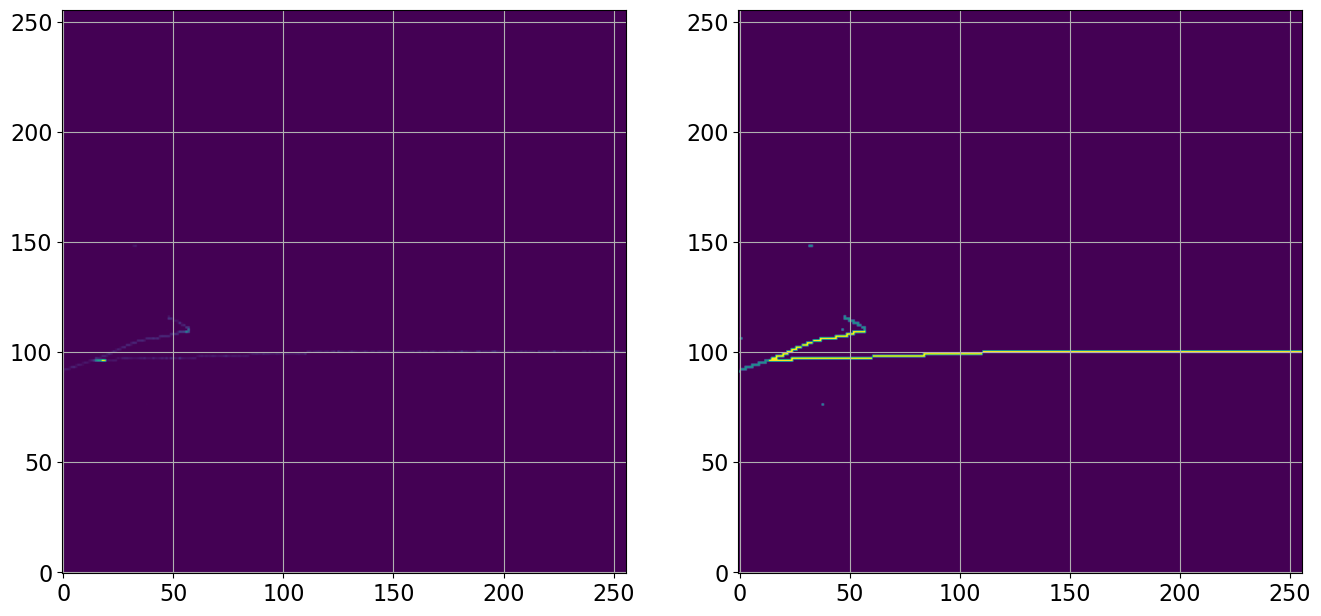

In [10]:
entry = 1
fig,axes=plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(f['image'][entry],origin='lower')
axes[1].imshow(f['label'][entry],origin='lower')
plt.show()

You can see the `label` image shows discrete color scales, basically 3 colors for 3 classes. We can double-check there are really 3 values.

In [4]:
print('Unique values in the label image',np.unique(f['label'][entry]))

Unique values in the label image [0. 1. 2.]


In [17]:
print('Unique values in the data image',np.unique(f['image'][entry]))

Unique values in the data image [   0.         10.591979   12.04797    19.698902   22.088297   22.778862
   24.923086   31.926313   34.23069    36.193813   36.399864   36.70557
   37.03684    37.406876   42.916492   44.879604   46.131374   46.811478
   48.971413   49.012558   51.023804   51.04986    51.593582   52.546776
   53.09039    53.20464    53.492218   53.635765   55.145954   55.32784
   55.330254   55.695564   56.271732   56.37756    56.383343   57.73289
   59.673195   59.91251    61.156517   61.888165   63.02368    64.17472
   64.85592    65.22029    65.917984   65.93076    66.7622     67.830154
   68.02986    68.42442    68.43825    68.45725    68.86142    68.95203
   69.24233    69.27214    69.32105    69.84792    69.91773    69.93138
   70.01347    70.25302    70.97643    71.039505   71.50622    72.30993
   73.20991    73.643234   73.905426   74.114655   74.36836    75.86313
   75.89782    76.29811    76.52697    76.96437    77.1245     77.17684
   78.22757    78.40495    7

Let's don't forget to close the file :)

In [5]:
f.close()

## Segmentation Image `Dataset` and `DataLoader`

We prepared a simple torch `Dataset` implementation for this dataset.

In [18]:
from iftool.segment_challenge import SegmentImage2D
train_data = SegmentImage2D(data_files=[datapath])

The dataset is index-accessible and produce a dictionary with four keys
* `data` ... 2D image of a particle (192x192 pixels) of floating point value (energy deposition)
* `label` ... 2D image of a particle (256x256 pixels) of integer type for classification
* `index` ... an index of the data entry from an input file

Size of dataset 25000
List of keys in a data element dict_keys(['data', 'label', 'index']) 

Again 5-th image!


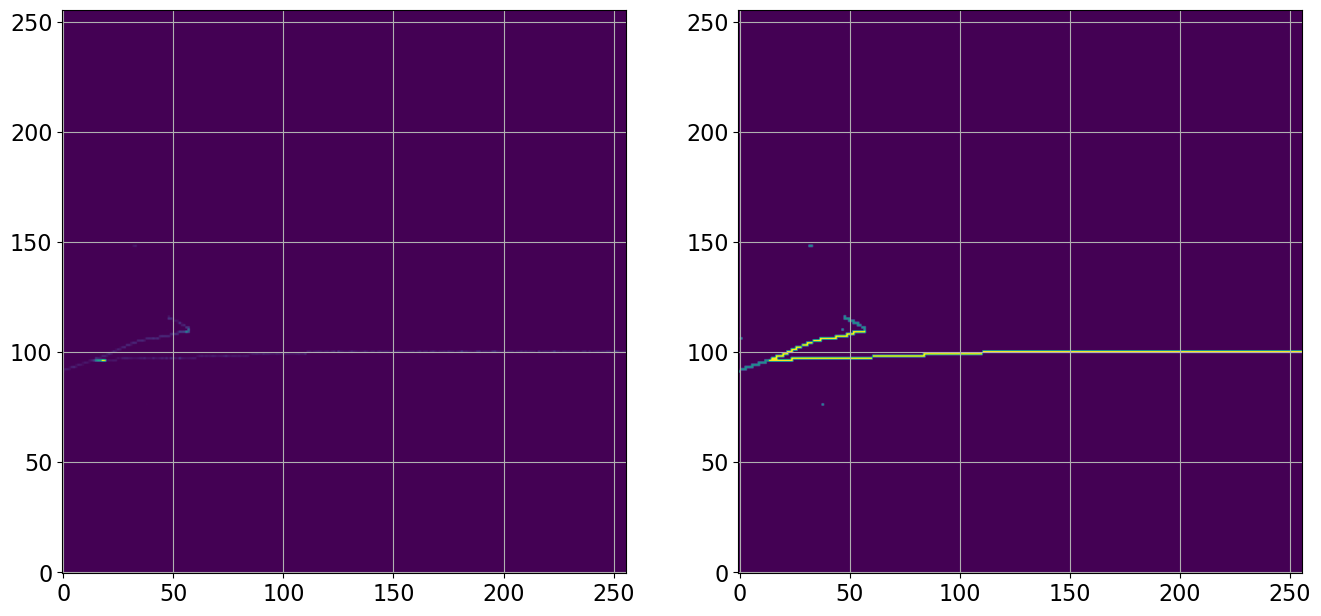

In [20]:
print('Size of dataset',len(train_data))

# Access the 5-th instance
data = train_data[1]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
print('Again 5-th image!')
fig,axes=plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(data['data'],origin='lower')
axes[1].imshow(data['label'],origin='lower')
plt.show()

Create a `DataLoader` instance in a usual way except we give a specifically designed collate function to handle a dictionary style data instance.

In [8]:
train_data = SegmentImage2D(data_files = [datapath],
                            num_class = 3,
                            start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                            end   = 0.5, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from iftool.segment_challenge import collate
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 4,
                          batch_size  = 64
                         )


Let's measure the speed of the dataloader

In [9]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.04781917333602905 [s/iteration]


## Challenge

Here are open-ended challenge project for an image segmentation.

* Design a deep neural network that performs image segmentation task, train, and report the performance.

* Produce the "software score map", an image which pixels showing the highest softmax score across semantic classes. Regions with the low score value are where the classification confidence is low. Do you see a pattern in low confidence regions?

* Inspect the learning process. Which class does your algorithm learn first? Where in the image the classification confidence becomes high in the earlier phase of the training?